### KPI Selection and Filtering

1. **Notebook Objective:**
	- This notebook will collect KPIs selected by the user for stocks identified from the Sharpe Ratio calculations
	- It will filter out stocks that underperform the SPY based on their Sharpe Ratio
	- The user can choose which KPIs to analyze
	- The notebook will then filter stocks based on whether their KPIs are above or below the sector median, according to user-defined criteria
	- It will also allow the user to plot the distribution of selected KPIs to identify trends or commonalities


In [2]:
import time
import os 

start_time = time.time() # measuring run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')

from utils.helpers import divide_chunks

import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, List, Optional
import pandas as pd
from tenacity import retry, stop_after_attempt, wait_exponential
from tqdm import tqdm
from functools import lru_cache
import yfinance as yf

Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Set up logging and batch processing to prevent rate limits or data request rejections.

In [3]:
# Setup logging, and batching to avoid kickbacks

logging.basicConfig(level=logging.INFO)

@lru_cache(maxsize=1000)
def fetch_ticker_info_cached(ticker_symbol: str) -> Dict[str, Optional[float]]:
    """
    Cached retrieval of ticker info from Yahoo Finance to minimize repeated API calls.
    """
    try:
        return yf.Ticker(ticker_symbol).info
    except Exception as e:
        logging.error(f"Error fetching data for {ticker_symbol}: {e}")
        return {}

@retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=4, max=10)
)

def fetch_with_retry(ticker: str) -> Dict[str, Optional[float]]:
    """
    Retry fetching data for a ticker symbol using tenacity.
    """
    return fetch_ticker_info_cached(ticker)

def get_stock_kpis(ticker: str, kpis: List[str]) -> Dict[str, Optional[float]]:
    """
    Fetch KPIs for a specific stock ticker.
    """
    try:
        info = fetch_with_retry(ticker)
        kpi_data = {kpi: info.get(kpi) for kpi in kpis}
        kpi_data['Tickers'] = ticker  # Add ticker column
        return kpi_data
    except Exception as e:
        logging.error(f"Error processing {ticker}: {e}")
        return {'Tickers': ticker, **{kpi: None for kpi in kpis}}


def batch_process_stocks(tickers: List[str], kpis: List[str], max_workers: int = 10) -> pd.DataFrame:
    """
    Process stock tickers in batches using ThreadPoolExecutor for parallel API calls.
    """
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ticker = {
            executor.submit(get_stock_kpis, ticker, kpis): ticker
            for ticker in tickers
        }

        for future in tqdm(as_completed(future_to_ticker), total=len(tickers)):
            results.append(future.result())

    # Create DataFrame from results
    df = pd.DataFrame(results)
    return df


In [4]:
# Find Benchmark Sharpe

sharpe_ratio_df = pd.read_csv(f'{WORKSPACE_DIR}/portfolio_py/data/clean/sharpe_ratios.csv')
spy_sharpe = sharpe_ratio_df.loc[sharpe_ratio_df['Tickers'] == 'SPY', 'Sharpe_ratios'].values[0]

# Filter only stocks above benchmark
sharpe_ratio_df = sharpe_ratio_df[sharpe_ratio_df['Sharpe_ratios'] >= spy_sharpe]

print(f'Spy Sharpe: {spy_sharpe.round(2)}')

Spy Sharpe: 0.4


In [5]:
# Fetch KPI's

num_in_chunks = 20
tickers = sharpe_ratio_df['Tickers'].tolist()

print('\n----Intiating Chunk Process----')
ticker_chunks = list(divide_chunks(tickers, num_in_chunks))
print(f'{len(tickers)} tikcers divided into {len(ticker_chunks)} chunks')
        
essential_kpis = ['marketCap', 'trailingPE', 'forwardPE', 
                  'profitMargins', 'trailingEps', 'quickRatio',
                  'earningsQuarterlyGrowth'
]

df_list = []

# Loop through each chunk and process the stocks
print('\n----Fethcing KPIs----')
for chunk in ticker_chunks:
    kpi_df_chunk = batch_process_stocks(chunk, essential_kpis)
    df_list.append(kpi_df_chunk)

# Concatenate all DataFrames vertically
kpi_df = pd.concat(df_list, axis=0, ignore_index=True).dropna()
print(f'KPI Df Shape: {kpi_df.shape}')


----Intiating Chunk Process----
56 tikcers divided into 3 chunks

----Fethcing KPIs----


100%|██████████| 16/16 [00:00<00:00, 52.84it/s]


KPI Df Shape: (38, 8)


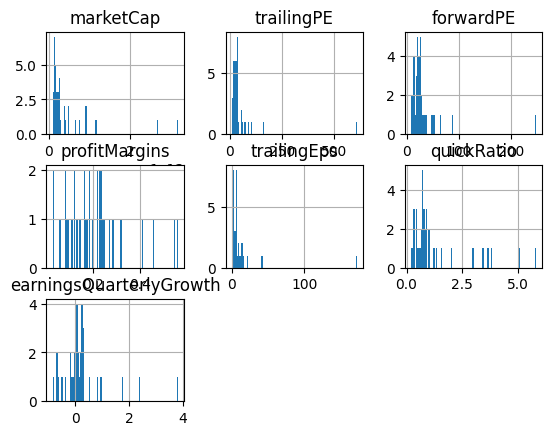

In [6]:
import numpy as np

# Minor data cleaning
kpi_df = kpi_df.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
kpi_df['trailingPE'] = kpi_df['trailingPE'].astype(float)
kpi_df.select_dtypes(include=['number']).hist(bins=100) # to view distribution

valuation_df = pd.merge(kpi_df, sharpe_ratio_df, on='Tickers').dropna()
median_values = valuation_df.describe().loc['50%'].to_dict() # Use median as the data often does not follow normal distrubution

# Get sectors
sector_dict = {} #ticker: sector
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=2, min=1, max=32))
def fetch_sector(ticker):
    return yf.Ticker(ticker).info.get('sector')

for chunk in ticker_chunks:
    for ticker in chunk:
        try:
            sector_dict[ticker] = fetch_sector(ticker)
        except Exception as e:
            print(f"Failed to fetch {ticker} after retries: {e}")

sector_df = pd.DataFrame(list(sector_dict.items()), columns=['Tickers', 'Sector'])
valuation_df = pd.merge(left=sector_df, right=valuation_df, right_on='Tickers', left_on='Tickers')

In [7]:
# used to view distrubution, how ever is fixed, and user will need to change

# print(kpi_df['earningsQuarterlyGrowth'].median())
# kpi_df['earningsQuarterlyGrowth'].hist(bins=100) # to view distribution

In [8]:
#filtering

grouped = valuation_df.groupby(['Sector']).median(numeric_only=True)

merged_df = pd.merge(valuation_df, grouped, on='Sector', suffixes=('_stock', '_sector'))

merged_df = merged_df[merged_df['Sharpe_ratios_stock'] >= merged_df['Sharpe_ratios_sector']] # above median sharpe, this is a performance measure
merged_df = merged_df[merged_df['profitMargins_stock'] >= merged_df['profitMargins_sector']] # above median prof margin, this is a performance measure
merged_df = merged_df[merged_df['trailingPE_stock'] <= merged_df['trailingPE_sector']] # below median trailing pe ratio, this is a risk adverse measure; sharpe ratio does not take into account over valuation
merged_df = merged_df[merged_df['quickRatio_stock'] >= merged_df['quickRatio_sector']] # above median quick ratio, this is a risk adverse measure; sharpe ratio does not take into account over leveraged
merged_df = merged_df[merged_df['earningsQuarterlyGrowth_stock'] >= 0]

stock_cols_only = [col for col in merged_df.columns if '_sector' not in col]
filtered_valuation_df = merged_df[stock_cols_only] # export only stock info, no need for sector info

filtered_valuation_df.columns = filtered_valuation_df.columns.str.replace('_stock', '', regex=False) # clean up excesive stock col name


filtered_valuation_df.to_csv(f'{WORKSPACE_DIR}/portfolio_py/data/clean/filtered_valuation_df.csv', index=False)
logging.info(f"Final filtered DataFrame saved. Rows: {filtered_valuation_df.shape[0]}")

# Print the sorted DataFrame (Optional)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'\nTotal Run Time: {elapsed_time} seconds')
filtered_valuation_df.reset_index(drop=True)

INFO:root:Final filtered DataFrame saved. Rows: 3



Total Run Time: 9.903995752334595 seconds


,Tickers,Sector,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,quickRatio,earningsQuarterlyGrowth,Sharpe_ratios
0,BABA,Consumer Cyclical,285574856704,17.430555,12.079534,0.12316,6.84,0.991,2.375,1.501411
1,BKNG,Consumer Cyclical,160327860224,28.454815,23.406576,0.24778,172.62,1.237,3.811,1.189560
2,GS,Financial Services,170918969344,12.771714,13.232676,0.28056,43.06,2.039,0.147,0.980237
